In [1]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm
import yfinance as yf

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/tmp/ipykernel_1127504/1806486080.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [3]:
import numpy as np
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset

dataset = get_dataset("covid_deaths", regenerate=False)

print(next(iter(dataset.train)))
print(type(dataset.train))

{'target': array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
       4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 6.000e+00,
       6.000e+00, 7.000e+00, 7.000e+00, 1.100e+01, 1.400e+01, 1.400e+01,
       1.500e+01, 1.500e+01, 1.800e+01, 

In [4]:
for entry in dataset.test:
    print(entry)

{'target': array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
       4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 6.000e+00,
       6.000e+00, 7.000e+00, 7.000e+00, 1.100e+01, 1.400e+01, 1.400e+01,
       1.500e+01, 1.500e+01, 1.800e+01, 

In [5]:
# Membuat dataset baru tanpa nol di awal target
def impute_zeros(dataset, freq):
    filtered_entries = []
    for entry in dataset:
        target = np.array(entry['target'])
        mean_value = target[target != 0].mean()
        target[target == 0] = mean_value

        new_entry = {
            'target': target,
            'start': entry['start'],
            'item_id': entry['item_id'],
        }

        if 'feat_static_cat' in entry:
            new_entry['feat_static_cat'] = entry['feat_static_cat']

        filtered_entries.append(new_entry)
    return ListDataset(filtered_entries, freq=freq)
    

# Preprocessing train and test dataset
train_imputed = impute_zeros(dataset.train, dataset.metadata.freq)
test_imputed = impute_zeros(dataset.test, dataset.metadata.freq)

# Preview hasil deleting zero values
print("Dataset setelah menghapus nol di awal:")
for entry in train_imputed:
    print(entry)


Dataset setelah menghapus nol di awal:
{'target': array([3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.4177048e+02, 3.4177048e+02, 3.4177048e+02, 3.4177048e+02,
       3.417

/tmp/ipykernel_1127504/3127687744.py:6: RuntimeWarning: Mean of empty slice.
  mean_value = target[target != 0].mean()
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    print(estimator.lags_seq)

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_1127504/3902027965.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU

In [7]:
context_length = 75
prediction_length = 20

[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


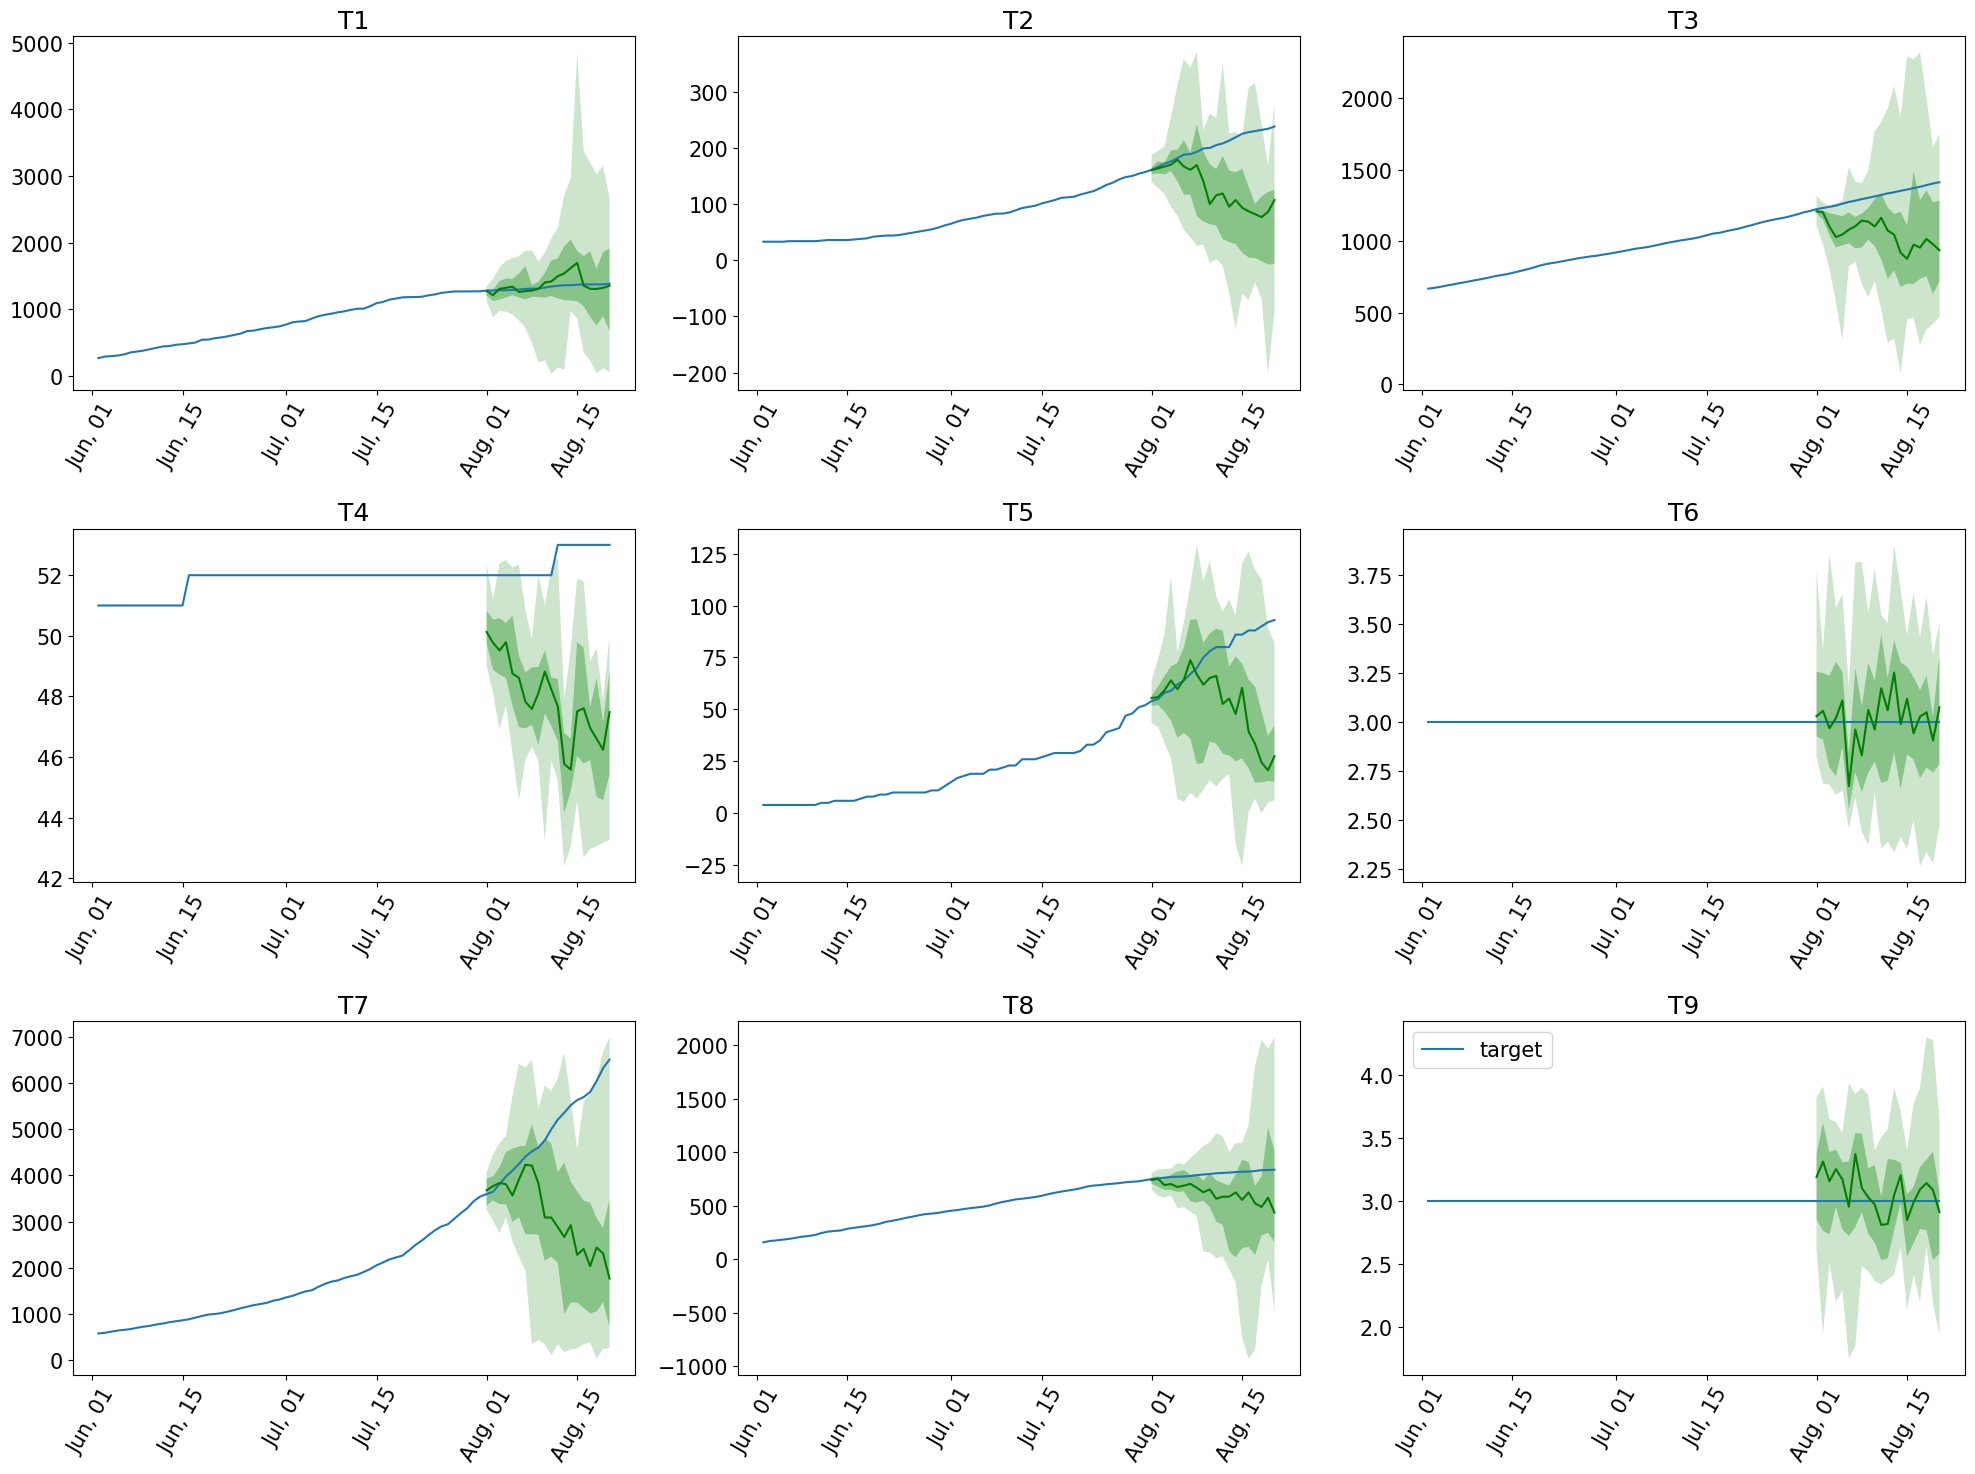

Running evaluation: 266it [00:00, 8339.70it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed 

CRPS: 0.16725597053299138
WQL: 0.06204823687215125
MSE: 24125674.838054456
MAPE: 0.165675721020146
RMSE: 4911.7893723219095
MASE: 32.11548225417741
{'MSE': 24125674.838054456, 'abs_error': 3104781.9070357084, 'abs_target_sum': 14723165.0, 'abs_target_mean': 3159.4774678111594, 'seasonal_error': 23.33153466480495, 'MASE': 32.11548225417741, 'MAPE': 0.165675721020146, 'sMAPE': 0.20729047653501126, 'MSIS': 477.8891673542025, 'num_masked_target_values': 660.0, 'QuantileLoss[0.1]': 1750455.8827699902, 'Coverage[0.1]': 0.13326180257510728, 'QuantileLoss[0.2]': 2622153.662016225, 'Coverage[0.2]': 0.13927038626609442, 'QuantileLoss[0.3]': 3069774.5847657444, 'Coverage[0.3]': 0.15, 'QuantileLoss[0.4]': 3288099.488811541, 'Coverage[0.4]': 0.192274678111588, 'QuantileLoss[0.5]': 3104781.9488301277, 'Coverage[0.5]': 0.2684549356223176, 'QuantileLoss[0.6]': 3204582.7769346954, 'Coverage[0.6]': 0.32274678111587984, 'QuantileLoss[0.7]': 2514211.1638505934, 'Coverage[0.7]': 0.45236051502145924, 'Quant

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [8]:
forecasts_it, tss_it= get_lag_llama_predictions(test_imputed, context_length = 75, prediction_length = 20, device = device, num_samples = 20, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])
print(agg_metrics)